# Projeto Final: Classificação de Reviews de Companhias Aéreas (Tabular vs Texto)

**Disciplina:** Inteligência Artificial
**Objetivo:** Comparar a eficácia de modelos preditivos utilizando dados estruturados (notas), dados não estruturados (texto) e uma abordagem híbrida.

---

## Módulo 0: Análise Exploratória e Diagnóstico de Dados (EDA)

**Objetivo:** Realizar o "check-up" inicial da base de dados, identificando a saúde dos dados, distribuição da variável alvo, correlações e definindo a estratégia de limpeza.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import nltk
import ssl
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

print("Baixando recursos do NLTK...")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
print("Ambiente configurado com sucesso.")

Baixando recursos do NLTK...


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/origami/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/origami/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/origami/nltk_data...


Ambiente configurado com sucesso.


[nltk_data]   Package omw-1.4 is already up-to-date!


In [33]:
try:
    df = pd.read_csv('airlines_reviews.csv')
    print(f"Dataset carregado! Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas.")
except FileNotFoundError:
    print("Erro: Arquivo não encontrado.")

df.head()

Dataset carregado! Dimensões: 8100 linhas x 17 colunas.


,Title,Name,Review Date,Airline,Verified,Reviews,Type of Traveller,Month Flown,Route,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended
0,Flight was amazing,Alison Soetantyo,2024-03-01,Singapore Airlines,True,Flight was amazing. The crew onboard this fl...,Solo Leisure,December 2023,Jakarta to Singapore,Business Class,4,4,4,4,4,9,yes
1,seats on this aircraft are dreadful,Robert Watson,2024-02-21,Singapore Airlines,True,Booking an emergency exit seat still meant h...,Solo Leisure,February 2024,Phuket to Singapore,Economy Class,5,3,4,4,1,3,no
2,Food was plentiful and tasty,S Han,2024-02-20,Singapore Airlines,True,Excellent performance on all fronts. I would...,Family Leisure,February 2024,Siem Reap to Singapore,Economy Class,1,5,2,1,5,10,yes
3,“how much food was available,D Laynes,2024-02-19,Singapore Airlines,True,Pretty comfortable flight considering I was f...,Solo Leisure,February 2024,Singapore to London Heathrow,Economy Class,5,5,5,5,5,10,yes
4,“service was consistently good”,A Othman,2024-02-19,Singapore Airlines,True,The service was consistently good from start ...,Family Leisure,February 2024,Singapore to Phnom Penh,Economy Class,5,5,5,5,5,10,yes


In [34]:
missing = df.isnull().sum()
if missing.sum() == 0:
    print(">> Diagnóstico: A base está PERFEITA em integridade (0% nulos).")
else:
    print(missing[missing > 0])

>> Diagnóstico: A base está PERFEITA em integridade (0% nulos).


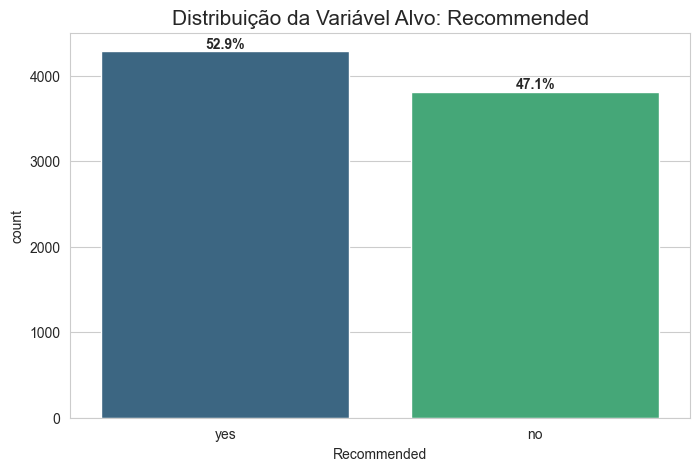

In [35]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Recommended', data=df, palette='viridis')
plt.title('Distribuição da Variável Alvo: Recommended', fontsize=15)

total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontweight='bold')
plt.show()

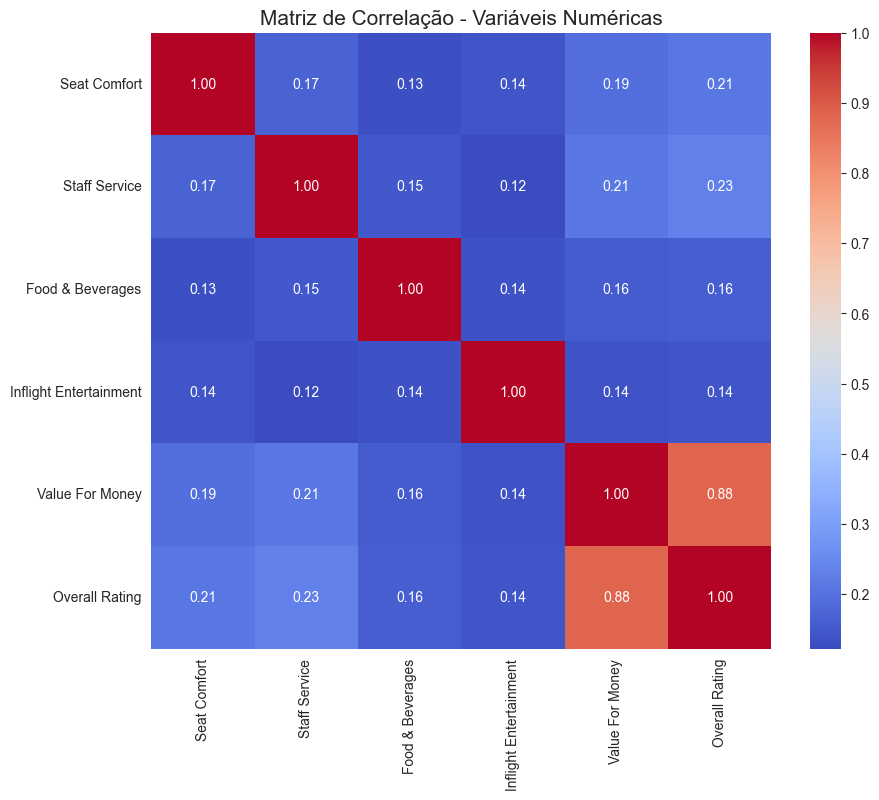

In [36]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação - Variáveis Numéricas', fontsize=15)
plt.show()

---
## Módulo 1: Pré-processamento e Engenharia de Atributos (Data Prep)

**Objetivo:** Transformar dados brutos em formatos numéricos aceitáveis. Inclui limpeza de texto (NLP) e codificação de variáveis categóricas.

In [37]:
df['target'] = df['Recommended'].map({'yes': 1, 'no': 0})

cols_to_drop = ['Name', 'Title', 'Route', 'Review Date', 'Month Flown', 'Recommended', 'Verified']
if 'Overall Rating' in df.columns:
    cols_to_drop.append('Overall Rating')

df_clean = df.drop(columns=cols_to_drop, errors='ignore')

class_map = {
    'Economy Class': 0,
    'Premium Economy': 1,
    'Business Class': 2,
    'First Class': 3
}
df_clean['Class_Encoded'] = df_clean['Class'].map(class_map)
df_clean.drop('Class', axis=1, inplace=True)

print("Dataset tabular limpo.")

Dataset tabular limpo.


In [38]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text_pipeline(text):
    if not isinstance(text, str):
        return ""
    text = text.lower() 
    text = re.sub(r'[^a-zA-Z\s]', '', text) 
    words = text.split()
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    return " ".join(cleaned_words)

print("Aplicando limpeza de texto (NLP). Aguarde...")
df_clean['Reviews_Clean'] = df_clean['Reviews'].apply(clean_text_pipeline)

# Check visual
print(f"ORIGINAL: {df['Reviews'].iloc[0][:60]}...")
print(f"LIMPO:    {df_clean['Reviews_Clean'].iloc[0][:60]}...")

Aplicando limpeza de texto (NLP). Aguarde...
ORIGINAL:   Flight was amazing. The crew onboard this flight were very...
LIMPO:    flight amazing crew onboard flight welcoming gave good atmos...


In [39]:
X = df_clean.drop(['target'], axis=1)
y = df_clean['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")

Treino: (6480, 10), Teste: (1620, 10)


---
## Módulo 2: Construção e Treinamento dos Modelos

Cenários:
1.  **Tabular Puro:** Apenas notas e categorias.
2.  **Texto Puro:** Apenas o review processado.
3.  **Híbrido:** Junção de ambos.

In [40]:
results = {}

numeric_features = ['Seat Comfort', 'Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Value For Money', 'Class_Encoded']
categorical_features = ['Airline', 'Type of Traveller']
text_feature = 'Reviews_Clean'

tabular_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [41]:
model_tabular = Pipeline(steps=[
    ('preprocessor', tabular_preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

model_tabular.fit(X_train, y_train)
y_pred_tab = model_tabular.predict(X_test)
acc_tab = accuracy_score(y_test, y_pred_tab)
results['Tabular'] = acc_tab
print(f"Acurácia Tabular: {acc_tab:.4f}")

Acurácia Tabular: 0.8969


In [42]:
model_text = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(max_features=3000)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

model_text.fit(X_train[text_feature], y_train)
y_pred_text = model_text.predict(X_test[text_feature])
acc_text = accuracy_score(y_test, y_pred_text)
results['Text'] = acc_text
print(f"Acurácia Texto: {acc_text:.4f}")

Acurácia Texto: 0.8969


In [43]:
hybrid_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('text', TfidfVectorizer(max_features=3000), text_feature)
    ])

model_hybrid = Pipeline(steps=[
    ('preprocessor', hybrid_preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

model_hybrid.fit(X_train, y_train)
y_pred_hybrid = model_hybrid.predict(X_test)
acc_hybrid = accuracy_score(y_test, y_pred_hybrid)
results['Hybrid'] = acc_hybrid
print(f"Acurácia Híbrida: {acc_hybrid:.4f}")

Acurácia Híbrida: 0.9253


---
## Módulo 3: Análise de Resultados e Interpretação

Comparação de performance e extração das palavras determinantes para a recomendação.

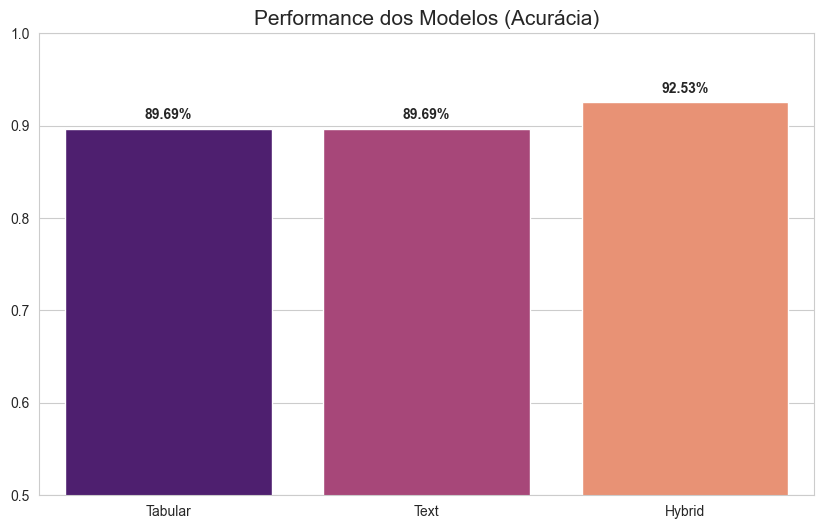

In [44]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='magma')
plt.title('Performance dos Modelos (Acurácia)', fontsize=15)
plt.ylim(0.5, 1.0)
for index, value in enumerate(results.values()):
    plt.text(index, value + 0.01, f"{value*100:.2f}%", ha='center', fontweight='bold')
plt.show()

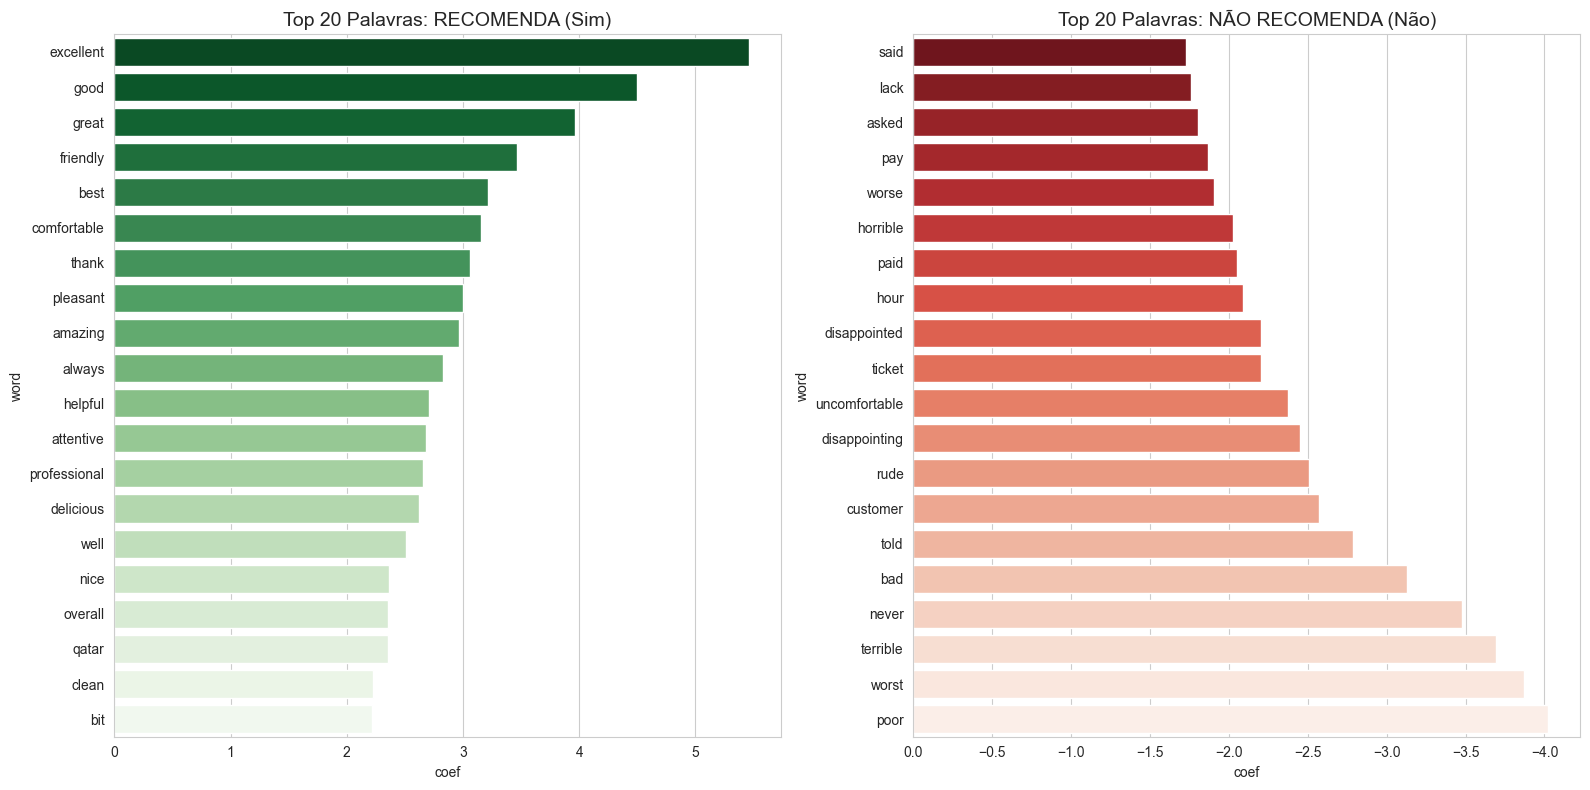

In [45]:
classifier = model_text.named_steps['classifier']
vectorizer = model_text.named_steps['vectorizer']

feature_names = vectorizer.get_feature_names_out()
coefs = classifier.coef_[0]

word_importance = pd.DataFrame({'word': feature_names, 'coef': coefs})
top_positive = word_importance.sort_values(by='coef', ascending=False).head(20)
top_negative = word_importance.sort_values(by='coef', ascending=True).head(20)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.barplot(ax=axes[0], x='coef', y='word', data=top_positive, palette='Greens_r')
axes[0].set_title('Top 20 Palavras: RECOMENDA (Sim)', fontsize=14)

sns.barplot(ax=axes[1], x='coef', y='word', data=top_negative.sort_values(by='coef', ascending=False), palette='Reds_r')
axes[1].set_title('Top 20 Palavras: NÃO RECOMENDA (Não)', fontsize=14)
axes[1].invert_xaxis()

plt.tight_layout()
plt.show()